This is a first script using the RandomForestRegressor (https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html). I'm not sure if this is a good approach but it's a start.

Next we need to think about better feature engineering.

Root Mean Squared Error: 0.33481073871832073
Predicted power consumption: 0.43794047431529637 kWh


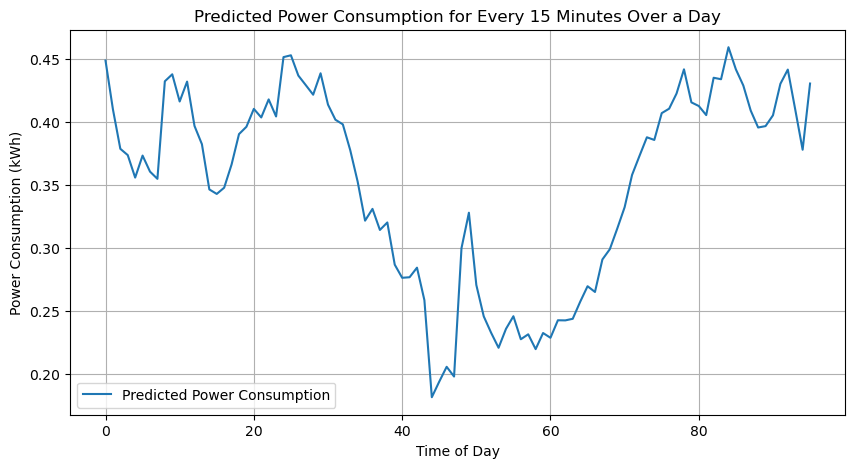

In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

# Load data, make sure that you set the correct file path
data = pd.read_csv('VO344_P40_export_20230301_20240326.csv', delimiter=';')

# Select all SM with complete data
clean_sm = pd.read_csv('CleanSmartmeterData.csv', delimiter=',')
data = data[data['PROFILE'].isin(clean_sm['PROFILE'])]

# Convert DATEFROM and TIMEFROM into a single datetime column
data['datetime'] = pd.to_datetime(data['DATEFROM'] + ' ' + data['TIMEFROM'])

# Feature Engineering, this part needs more work
data['minute'] = data['datetime'].dt.minute # Minute
data['hour'] = data['datetime'].dt.hour # Hour of day
data['day_of_week'] = data['datetime'].dt.dayofweek # Weekday
data['season'] = data['datetime'].dt.quarter # Season

# Select features and target
X = data[['hour', 'minute', 'day_of_week', 'season']] 
y = data['VALUE']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the model with https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Make predictions
predictions = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error: {rmse}')

# Predict a new data point at 2 AM on a Monday
new_data = pd.DataFrame({'hour': [2], 'minute': [15], 'day_of_week': [0], 'season': [1]})
new_prediction = model.predict(new_data)
print(f'Predicted power consumption: {new_prediction[0]} kWh')

# Generate data points for an entire day in 15-minute intervals
intervals_per_hour = 4
hours = np.repeat(np.arange(24), intervals_per_hour)
minutes = np.tile(np.arange(0, 60, 15), 24)
day_of_week = np.zeros(24 * intervals_per_hour)  # Assuming Monday (day_of_week = 0)

new_data = pd.DataFrame({
    'hour': hours,
    'minute': minutes,
    'day_of_week': day_of_week,
    'season': 1
})

# Predict the whole day
day_predictions = model.predict(new_data)

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(day_predictions, label='Predicted Power Consumption')
# plt.xticks(ticks=np.arange(0, 96, 4), labels=[f'{i}:00' for i in range(24)])
plt.xlabel('Time of Day')
plt.ylabel('Power Consumption (kWh)')
plt.title('Predicted Power Consumption for Every 15 Minutes Over a Day')
plt.grid(True)
plt.legend()
plt.show()

In [9]:
# Compute standart deviation of value
standard_deviation = np.std(y)
print(f'Standard Deviation of the target variable: {standard_deviation}')

# Comparison to calculated RMSE
rmse = 0.34465821291282195
print(f'RMSE: {rmse}')

comparison = "better" if rmse < standard_deviation else "worse"
print(f'The RMSE is {comparison} than the standard deviation of the target variable.')

Standard Deviation of the target variable: 0.35362333395319834
RMSE: 0.34465821291282195
The RMSE is better than the standard deviation of the target variable.
